### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph


In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.1168*1,0],
    [0.1168*2,0], 
    [0.1168*3,0],
    [0.1168*4,0],
    [0.1168*5,0],
    [0.1168*6,0],
    [0.1168*7,0],
    [0.1168*8,0],
    [0.1168*9,0], 
    [0.1168*10,0],
    [0.1168*11,0],
    [0.1168*12,0],

] 

#wgs84

# for each edge (between above coordinates) specify the depth (m)
depths = [18,18,18,18,18,18,18,18,18,18,18,18,]
current_speeds = [0,0,0,0,0,0,0,0,0,0,0,0] 
V_g_profile = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile": V_g_profile[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

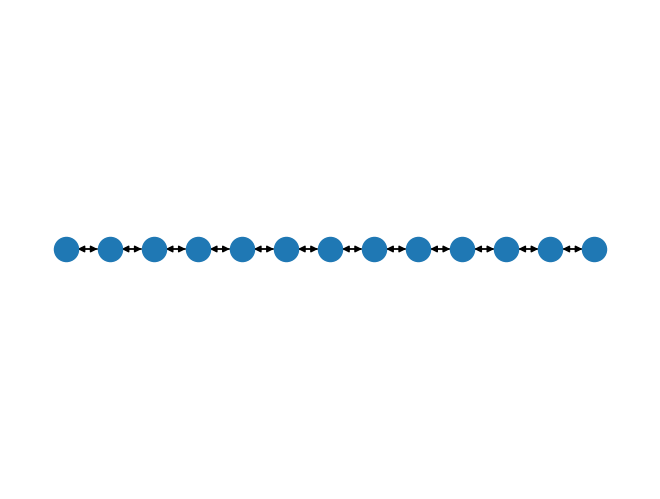

In [4]:
# show graph
nx.draw(FG, positions)
plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
# for edge in FG.edges:
#     print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
#     print('Current speed for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["CurrentSpeed"]))
#     print('Vessel Speed To Ground Profile {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile"]))

### Create vessel - add VesselProperties and ConsumesEnergy mixins


In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

#### hopper900L


In [7]:
# Create a dict with all important settings

data_vessel_01 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 5.14,  # m/s
    "type": None,
    "B": 10,
    "L": 62,
    "H_e": None, 
    "H_f": None, 
    "T": 3.4,
    "safety_margin": 0.3,                                      # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True,                                            #  if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker",                                    #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":False,                                        # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 900, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False,                                       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream": False,
    "consider_passive_rudder_resistance": False,
    "consider_wind_influence":False,
    "U_wind": 10, # m/s
    "rel_winddir": 10, #degree
    "load": 'loaded',
    "loaded_depth": 3.45 ,
    "unloaded_depth": 1.7,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.8, 
    "C_year": 2000,
}             



In [8]:
#### Hopper900U
data_vessel_02 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 5.14,  # m/s
    "type": None,
    "B": 10,
    "L": 60,
    "H_e": None, 
    "H_f": None, 
    "T": 3.18,
    "safety_margin": 0.3,                                      # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True,                                            #  if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker",                                    #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":False,                                        # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 900, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False,                                       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream": False,
    "consider_passive_rudder_resistance": False,
    "consider_wind_influence":False,
    "U_wind": 10, # m/s
    "rel_winddir": 10, #degree
    "load": 'unloaded',
    "loaded_depth": 3.45 ,
    "unloaded_depth": 1.7,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.8, 
    "C_year": 2000,
}             



In [9]:
#### Hopper 1125L
data_vessel_03 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 5.14,  # m/s
    "type": None,
    "B": 11,
    "L": 65,
    "H_e": None, 
    "H_f": None, 
    "T": 3.75,
    "safety_margin": 0.3,                                      # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True,                                            #  if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker",                                    #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":False,                                        # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 1570, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False,                                       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream": False,
    "consider_passive_rudder_resistance": False,
    "consider_wind_influence":False,
    "U_wind": 10, # m/s
    "rel_winddir": 10, #degree
    "load": 'loaded',
    "loaded_depth": 3.45 ,
    "unloaded_depth": 1.7,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.8, 
    "C_year": 2000,
}             



In [10]:
### Hopper 1125U
data_vessel_04 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 5.14,  # m/s
    "type": None,
    "B": 11,
    "L": 65,
    "H_e": None, 
    "H_f": None, 
    "T": 2.15,
    "safety_margin": 0.3,                                      # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True,                                            #  if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker",                                    #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":False,                                        # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 1570, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False,                                       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream": False,
    "consider_passive_rudder_resistance": False,
    "consider_wind_influence":False,
    "U_wind": 10, # m/s
    "rel_winddir": 10, #degree
    "load": 'unloaded',
    "loaded_depth": 3.45 ,
    "unloaded_depth": 1.7,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.8, 
    "C_year": 2000,
}             




In [11]:
### Hopper 1580L
data_vessel_05 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 5.66,  # m/s
    "type": None,
    "B": 14,
    "L": 79,
    "H_e": None, 
    "H_f": None, 
    "T": 3.35,
    "safety_margin": 0.3,                                      # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True,                                            #  if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker",                                    #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":False,                                        # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 2000, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False,                                       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream": False,
    "consider_passive_rudder_resistance": False,
    "consider_wind_influence":False,
    "U_wind": 10, # m/s
    "rel_winddir": 10, #degree
    "load": 'loaded',
    "loaded_depth": 3.35 ,
    "unloaded_depth": 1.7,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.8, 
    "C_year": 2000,
}             



In [12]:
### Hopper 1580U
data_vessel_06 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 5.66,  # m/s
    "type": None,
    "B": 14,
    "L": 79,
    "H_e": None, 
    "H_f": None, 
    "T": 2.35,
    "safety_margin": 0.3,                                      # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True,                                            #  if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker",                                    #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":False,                                        # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 2000, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False,                                       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream": False,
    "consider_passive_rudder_resistance": False,
    "consider_wind_influence":False,
    "U_wind": 10, # m/s
    "rel_winddir": 10, #degree
    "load": 'unloaded',
    "loaded_depth": 2.35 ,
    "unloaded_depth": 1.7,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.8, 
    "C_year": 2000,
}             



In [13]:
### Hopper 2500L
data_vessel_07 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 5.66,  # m/s
    "type": None,
    "B": 15,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 6.5,
    "safety_margin": 0.3,                                      # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True,                                            #  if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker",                                    #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":False,                                        # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed":3000, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False,                                       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream": False,
    "consider_passive_rudder_resistance": False,
    "consider_wind_influence":False,
    "U_wind": 7.7, # m/s
    "rel_winddir": 10, #degree
    "load": 'loaded',
    "loaded_depth": 6.5 ,
    "unloaded_depth": 1.7,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.8, 
    "C_year": 2000,
}             



In [14]:
### Hopper 2500U
data_vessel_08 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 5.66,  # m/s
    "type": None,
    "B": 15,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 5.7,
    "safety_margin": 0.3,                                      # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True,                                            #  if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker",                                    #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":False,                                        # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 3000, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False,                                       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream": False,
    "consider_passive_rudder_resistance": False,
    "consider_wind_influence":False,
    "U_wind": 10, # m/s
    "rel_winddir": 10, #degree
    "load": 'unloaded',
    "loaded_depth": 3.45 ,
    "unloaded_depth": 1.7,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.8, 
    "C_year": 2000,
}             



In [15]:
### Hopper 4280L
data_vessel_09 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave":6.17,  # m/s
    "type": None,
    "B": 19,
    "L": 91,
    "H_e": None, 
    "H_f": None, 
    "T": 6.8,
    "safety_margin": 0.3,                                      # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True,                                            #  if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker",                                    #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":False,                                        # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 9400, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False,                                       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream": False,
    "consider_passive_rudder_resistance": False,
    "consider_wind_influence":False,
    "U_wind": 10, # m/s
    "rel_winddir": 10, #degree
    "load": 'loaded',
    "loaded_depth": 3.45 ,
    "unloaded_depth": 1.7,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.8, 
    "C_year": 2000,
}             



In [16]:
### Hopper 4280U
data_vessel_10 = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "V_g_ave": 6.17,  # m/s
    "type": None,
    "B": 19,
    "L": 91,
    "H_e": None, 
    "H_f": None, 
    "T": 5.9,
    "safety_margin": 0.3,                                      # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True,                                            #  if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker",                                    #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "V_g_profile":False,                                        # if use the V_g_profile to determine V_w, set to True, otherwise (use the V_g_ave to determine V_w) set to False.
    "P_installed": 9400, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False,                                       # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream": False,
    "consider_passive_rudder_resistance": False,
    "consider_wind_influence":False,
    "U_wind": 10, # m/s
    "rel_winddir": 10, #degree
    "load": 'unloaded',
    "loaded_depth": 3.45 ,
    "unloaded_depth": 1.7,
    "Height_ship": 4,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.8, 
    "C_year": 2000,
}             



### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [17]:
path_upstream = nx.dijkstra_path(FG, nodes[0].name, nodes[12].name)
path_downstream = nx.dijkstra_path(FG, nodes[12].name, nodes[0].name)

### Define simulation

In [18]:
def run_simulation_01(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_01)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

def run_simulation_02(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_02)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.2'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

def run_simulation_03(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_03)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.3'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

def run_simulation_04(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_04)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.4'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

def run_simulation_05(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_05)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.5'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel
def run_simulation_06(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_06)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.6'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

def run_simulation_07(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_07)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.7'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

def run_simulation_08(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_08)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.8'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel
def run_simulation_09(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_09)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.9'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

def run_simulation_10(V_g_ave, path):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel_10)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.10'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.V_g_ave = V_g_ave

    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel


### Run simulation


In [19]:
# create empty plot data

vessel_01 = run_simulation_01(V_g_ave = 5.14 , path = path_upstream)
vessel_02 = run_simulation_02(V_g_ave = 5.14 , path = path_upstream)
vessel_03 = run_simulation_03(V_g_ave = 5.14 , path = path_upstream)
vessel_04 = run_simulation_04(V_g_ave = 5.14 , path = path_upstream)
vessel_05 = run_simulation_05(V_g_ave = 5.66 , path = path_upstream)
vessel_06 = run_simulation_06(V_g_ave = 5.66, path = path_upstream)
vessel_07 = run_simulation_07(V_g_ave = 5.66 , path = path_upstream)
vessel_08 = run_simulation_08(V_g_ave = 5.66 , path = path_upstream)
vessel_09 = run_simulation_09(V_g_ave = 6.17 , path = path_upstream)
vessel_10 = run_simulation_10(V_g_ave = 6.17 , path = path_upstream)


# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_01 = opentnsim.energy.EnergyCalculation(FG, vessel_01)
energycalculation_02 = opentnsim.energy.EnergyCalculation(FG, vessel_02)
energycalculation_03 = opentnsim.energy.EnergyCalculation(FG, vessel_03)
energycalculation_04 = opentnsim.energy.EnergyCalculation(FG, vessel_04)
energycalculation_05 = opentnsim.energy.EnergyCalculation(FG, vessel_05)
energycalculation_06 = opentnsim.energy.EnergyCalculation(FG, vessel_06)
energycalculation_07 = opentnsim.energy.EnergyCalculation(FG, vessel_07)
energycalculation_08 = opentnsim.energy.EnergyCalculation(FG, vessel_08)
energycalculation_09 = opentnsim.energy.EnergyCalculation(FG, vessel_09)
energycalculation_10 = opentnsim.energy.EnergyCalculation(FG, vessel_10)

energycalculation_01.calculate_energy_consumption()
energycalculation_02.calculate_energy_consumption()
energycalculation_03.calculate_energy_consumption()
energycalculation_04.calculate_energy_consumption()
energycalculation_05.calculate_energy_consumption()
energycalculation_06.calculate_energy_consumption()
energycalculation_07.calculate_energy_consumption()
energycalculation_08.calculate_energy_consumption()
energycalculation_09.calculate_energy_consumption()
energycalculation_10.calculate_energy_consumption()


# create dataframe from energy calculation computation
df_1 = pd.DataFrame.from_dict(energycalculation_01.energy_use)
df_2 = pd.DataFrame.from_dict(energycalculation_02.energy_use)
df_3 = pd.DataFrame.from_dict(energycalculation_03.energy_use)
df_4 = pd.DataFrame.from_dict(energycalculation_04.energy_use)
df_5 = pd.DataFrame.from_dict(energycalculation_05.energy_use)
df_6 = pd.DataFrame.from_dict(energycalculation_06.energy_use)
df_7 = pd.DataFrame.from_dict(energycalculation_07.energy_use)
df_8 = pd.DataFrame.from_dict(energycalculation_08.energy_use)
df_9 = pd.DataFrame.from_dict(energycalculation_09.energy_use)
df_10 = pd.DataFrame.from_dict(energycalculation_10.energy_use)

df_1.head(2)




C:\Users\NLFLKO\Anaconda3\envs\sim3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2023-03-21 16:23:38.000000,2023-03-21 17:05:47.594655,POINT (0 0),POINT (0.1168 0),524.601621,524.601621,900,368.619293,77336.873941,85070.365674,...,4.188856e+06,3.314922,0.230387,245214.478351,110.585788,3442.227969,368.619293,17.861776,13002.116525,2529.594655
1,2023-03-21 17:05:47.594655,2023-03-21 17:47:57.189309,POINT (0.1168 0),POINT (0.2336 0),524.601621,524.601621,900,368.619293,77336.873911,85070.365640,...,4.188856e+06,3.314922,0.230387,245214.478254,110.585788,3442.227968,368.619293,17.861776,13002.116525,2529.594654


In [20]:
df_2.head(2)

,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2023-03-21 16:23:38.000000,2023-03-21 17:05:47.594655,POINT (0 0),POINT (0.1168 0),511.996745,511.996745,900,359.762286,75685.244114,83253.577042,...,4.088208e+06,3.235272,0.224851,239977.603287,107.928686,3368.992375,359.762286,17.869066,13002.116525,2529.594655
1,2023-03-21 17:05:47.594655,2023-03-21 17:47:57.189309,POINT (0.1168 0),POINT (0.2336 0),511.996745,511.996745,900,359.762286,75685.244084,83253.577009,...,4.088208e+06,3.235272,0.224851,239977.603192,107.928686,3368.992374,359.762286,17.869066,13002.116525,2529.594654


In [21]:
df_3.head(2)

,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2023-03-21 16:23:38.000000,2023-03-21 17:05:47.594655,POINT (0 0),POINT (0.1168 0),574.591325,574.591325,1570,403.745318,89687.782154,98656.333460,...,4.588015e+06,3.630803,0.252341,284375.894635,126.405469,3896.931374,403.745318,17.838349,13002.116525,2529.594655
1,2023-03-21 17:05:47.594655,2023-03-21 17:47:57.189309,POINT (0.1168 0),POINT (0.2336 0),574.591325,574.591325,1570,403.745318,89687.782119,98656.333421,...,4.588015e+06,3.630803,0.252341,284375.894522,126.405469,3896.931373,403.745318,17.838349,13002.116525,2529.594654


In [22]:
df_4.head(2)

,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2023-03-21 16:23:38.000000,2023-03-21 17:05:47.594655,POINT (0 0),POINT (0.1168 0),441.212042,441.212042,1570,310.024340,71028.375642,78131.033505,...,3.523004e+06,2.787989,0.193765,225211.922768,101.859605,3052.914868,310.024340,17.896988,13002.116525,2529.594655
1,2023-03-21 17:05:47.594655,2023-03-21 17:47:57.189309,POINT (0.1168 0),POINT (0.2336 0),441.212042,441.212042,1570,310.024339,71028.375614,78131.033474,...,3.523004e+06,2.787989,0.193765,225211.922679,101.859605,3052.914866,310.024339,17.896988,13002.116525,2529.594654


In [23]:
df_5.head(2)

,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2023-03-21 16:23:38.000000,2023-03-21 17:01:55.193732,POINT (0 0),POINT (0.1168 0),960.450081,960.450081,2000,612.872196,131161.252607,144277.046030,...,6.964457e+06,5.511441,0.383045,415877.142411,185.700275,5783.783345,612.872196,17.780825,13002.116525,2297.193732
1,2023-03-21 17:01:55.193732,2023-03-21 17:40:12.387465,POINT (0.1168 0),POINT (0.2336 0),960.450081,960.450081,2000,612.872196,131161.252664,144277.046093,...,6.964457e+06,5.511441,0.383045,415877.142592,185.700275,5783.783347,612.872196,17.780825,13002.116525,2297.193733


In [24]:
df_6.head(2)

,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2023-03-21 16:23:38.000000,2023-03-21 17:01:55.193732,POINT (0 0),POINT (0.1168 0),849.282157,849.282157,2000,541.934902,117778.404243,129555.946689,...,6.158351e+06,4.873515,0.338709,373443.720771,165.855422,5170.966585,541.934902,17.835536,13002.116525,2297.193732
1,2023-03-21 17:01:55.193732,2023-03-21 17:40:12.387465,POINT (0.1168 0),POINT (0.2336 0),849.282157,849.282157,2000,541.934902,117778.404294,129555.946745,...,6.158351e+06,4.873515,0.338709,373443.720933,165.855422,5170.966587,541.934902,17.835536,13002.116525,2297.193733


In [25]:
df_7.head(2)

,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2023-03-21 16:23:38.000000,2023-03-21 17:01:55.193732,POINT (0 0),POINT (0.1168 0),1510.797429,1510.797429,3000,964.053996,205394.051404,225932.936898,...,1.095516e+07,8.66955,0.602534,651249.431280,291.900175,9062.107560,964.053996,17.603508,13002.116525,2297.193732
1,2023-03-21 17:01:55.193732,2023-03-21 17:40:12.387465,POINT (0.1168 0),POINT (0.2336 0),1510.797429,1510.797429,3000,964.053996,205394.051493,225932.936997,...,1.095516e+07,8.66955,0.602534,651249.431563,291.900175,9062.107564,964.053996,17.603508,13002.116525,2297.193733


In [ ]:
df_8.head(2)

,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2023-03-21 16:23:38.000000,2023-03-21 17:01:55.193732,POINT (0 0),POINT (0.1168 0),1381.523618,1381.523618,3000,881.563165,189376.673854,208313.862118,...,1.001776e+07,7.927726,0.550977,600462.624416,267.113639,8352.145588,881.563165,17.643521,13002.116525,2297.193732
1,2023-03-21 17:01:55.193732,2023-03-21 17:40:12.387465,POINT (0.1168 0),POINT (0.2336 0),1381.523618,1381.523618,3000,881.563166,189376.673937,208313.862208,...,1.001776e+07,7.927726,0.550977,600462.624677,267.113639,8352.145591,881.563166,17.643521,13002.116525,2297.193733


In [27]:
df_9.head(2)

,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2023-03-21 16:23:38.000000,2023-03-21 16:58:45.312241,POINT (0 0),POINT (0.1168 0),2597.543322,2597.543322,9400,1520.509678,348942.647103,383836.028990,...,1.727852e+07,13.673648,0.950319,1.106404e+06,501.281243,14999.801621,1520.509678,17.404065,13002.116525,2107.312241
1,2023-03-21 16:58:45.312241,2023-03-21 17:33:52.624481,POINT (0.1168 0),POINT (0.2336 0),2597.543322,2597.543322,9400,1520.509677,348942.646937,383836.028808,...,1.727852e+07,13.673648,0.950319,1.106404e+06,501.281243,14999.801614,1520.509677,17.404065,13002.116525,2107.312240


In [28]:
df_10.head(2)

,time_start,time_stop,edge_start,edge_stop,P_tot,P_given,P_installed,total_energy,total_diesel_consumption_C_year_ICE_mass,total_diesel_consumption_ICE_mass,...,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num,total_emission_CO2,total_emission_PM10,total_emission_NOX,stationary,water depth,distance,delta_t
0,2023-03-21 16:23:38.000000,2023-03-21 16:58:45.312241,POINT (0 0),POINT (0.1168 0),2365.364102,2365.364102,9400,1384.600202,320557.062591,352611.957842,...,1.573409e+07,12.451441,0.865375,1.016400e+06,464.682524,13787.647157,1384.600202,17.468802,13002.116525,2107.312241
1,2023-03-21 16:58:45.312241,2023-03-21 17:33:52.624481,POINT (0.1168 0),POINT (0.2336 0),2365.364102,2365.364102,9400,1384.600201,320557.062438,352611.957675,...,1.573409e+07,12.451441,0.865375,1.016400e+06,464.682524,13787.647150,1384.600201,17.468802,13002.116525,2107.312240


In [29]:
# x = np.linspace(1,12,12)
# plt.plot(x, df_upstream['P_tot'])
# #dip?

In [30]:
# plt.plot(x, df_upstream['total_energy'])
# plt.xlabel('m/s')
# plt.ylabel('kWh')
# plt.title('Energy consumption loaded barge for 1114 m, delta t = 557 s')
# # eenheid?


In [31]:
from opentnsim.energy import ConsumesEnergy

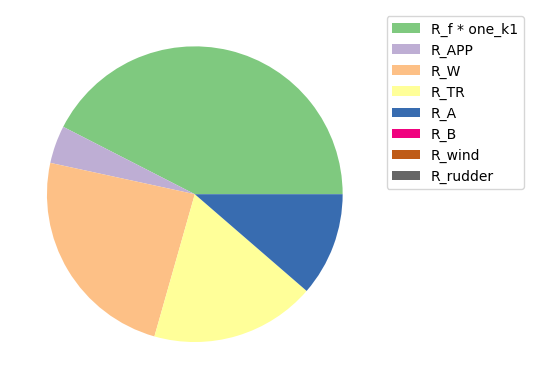

In [32]:
fractions_01 = np.abs(energycalculation_01.fractions());
import matplotlib.cm as cm


plt.figure()
# voor welke snelheid is dit dan? of het geheel.

labels = ["R_f * one_k1", "R_APP", "R_W", "R_TR", "R_A", "R_B", "R_wind", "R_rudder"]
colormap = 'Pastel1'

colors = cm.Accent(np.linspace(0, 1, len(fractions_01)))
plt.pie(fractions_01, colors=colors)
# plt.legend(labels=labels, loc='right')

plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,1))


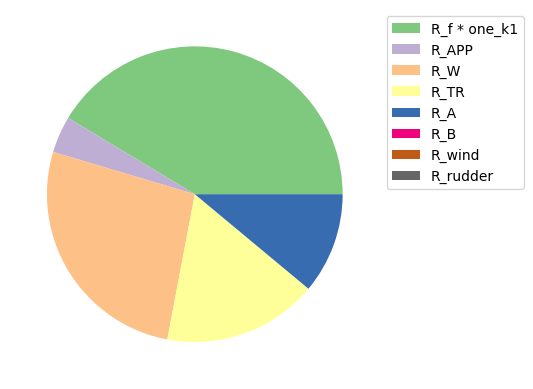

In [33]:
fractions_02 = np.abs(energycalculation_02.fractions());
import matplotlib.cm as cm


plt.figure()
# voor welke snelheid is dit dan? of het geheel.

labels = ["R_f * one_k1", "R_APP", "R_W", "R_TR", "R_A", "R_B", "R_wind", "R_rudder"]
colormap = 'Pastel1'

colors = cm.Accent(np.linspace(0, 1, len(fractions_02)))
plt.pie(fractions_02, colors=colors)
# plt.legend(labels=labels, loc='right')

plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,1))

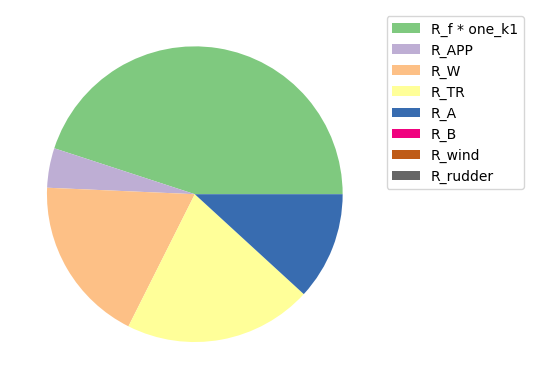

In [34]:
fractions_03 = np.abs(energycalculation_03.fractions());
import matplotlib.cm as cm


plt.figure()
# voor welke snelheid is dit dan? of het geheel.

labels = ["R_f * one_k1", "R_APP", "R_W", "R_TR", "R_A", "R_B", "R_wind", "R_rudder"]
colormap = 'Pastel1'

colors = cm.Accent(np.linspace(0, 1, len(fractions_03)))
plt.pie(fractions_03, colors=colors)
# plt.legend(labels=labels, loc='right')

plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,1))

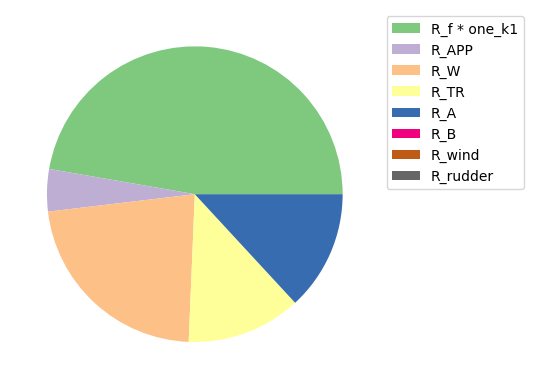

In [35]:
fractions_04 = np.abs(energycalculation_04.fractions());
import matplotlib.cm as cm


plt.figure()
# voor welke snelheid is dit dan? of het geheel.

labels = ["R_f * one_k1", "R_APP", "R_W", "R_TR", "R_A", "R_B", "R_wind", "R_rudder"]
colormap = 'Pastel1'

colors = cm.Accent(np.linspace(0, 1, len(fractions_04)))
plt.pie(fractions_04, colors=colors)
# plt.legend(labels=labels, loc='right')

plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,1))

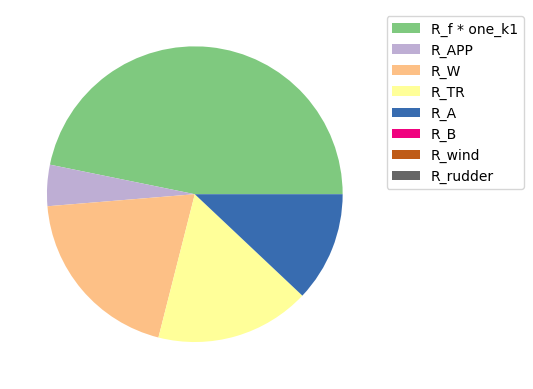

In [36]:
fractions_05 = np.abs(energycalculation_05.fractions());
import matplotlib.cm as cm


plt.figure()
# voor welke snelheid is dit dan? of het geheel.

labels = ["R_f * one_k1", "R_APP", "R_W", "R_TR", "R_A", "R_B", "R_wind", "R_rudder"]
colormap = 'Pastel1'

colors = cm.Accent(np.linspace(0, 1, len(fractions_05)))
plt.pie(fractions_05, colors=colors)
# plt.legend(labels=labels, loc='right')

plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,1))

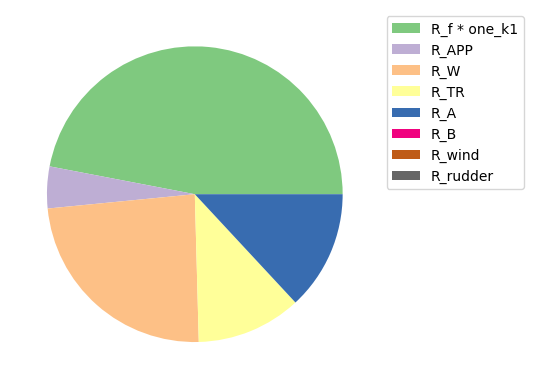

In [37]:
fractions_06 = np.abs(energycalculation_06.fractions());
import matplotlib.cm as cm


plt.figure()
# voor welke snelheid is dit dan? of het geheel.

labels = ["R_f * one_k1", "R_APP", "R_W", "R_TR", "R_A", "R_B", "R_wind", "R_rudder"]
colormap = 'Pastel1'

colors = cm.Accent(np.linspace(0, 1, len(fractions_06)))
plt.pie(fractions_06, colors=colors)
# plt.legend(labels=labels, loc='right')

plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,1))

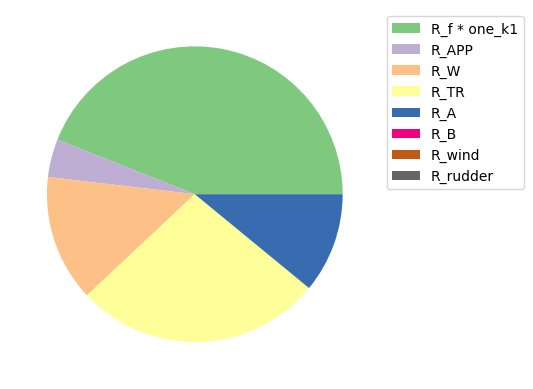

In [38]:
fractions_07 = np.abs(energycalculation_07.fractions());
import matplotlib.cm as cm


plt.figure()
# voor welke snelheid is dit dan? of het geheel.

labels = ["R_f * one_k1", "R_APP", "R_W", "R_TR", "R_A", "R_B", "R_wind", "R_rudder"]
colormap = 'Pastel1'

colors = cm.Accent(np.linspace(0, 1, len(fractions_07)))
plt.pie(fractions_07, colors=colors)
# plt.legend(labels=labels, loc='right')

plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,1))

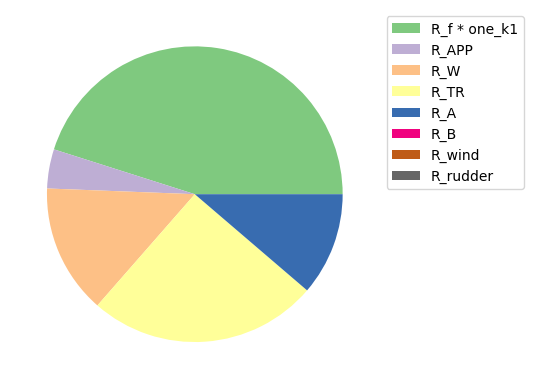

In [39]:
fractions_08 = np.abs(energycalculation_08.fractions());
import matplotlib.cm as cm


plt.figure()
# voor welke snelheid is dit dan? of het geheel.

labels = ["R_f * one_k1", "R_APP", "R_W", "R_TR", "R_A", "R_B", "R_wind", "R_rudder"]
colormap = 'Pastel1'

colors = cm.Accent(np.linspace(0, 1, len(fractions_08)))
plt.pie(fractions_08, colors=colors)
# plt.legend(labels=labels, loc='right')

plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,1))

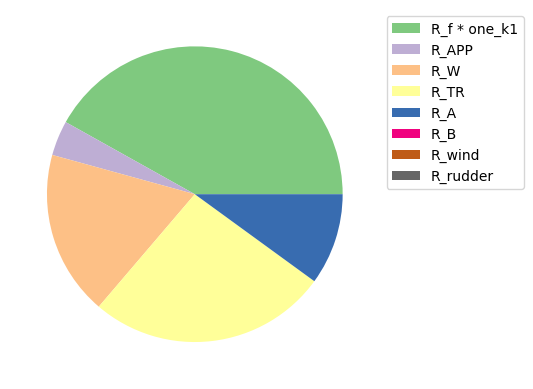

In [40]:
fractions_09 = np.abs(energycalculation_09.fractions());
import matplotlib.cm as cm


plt.figure()
# voor welke snelheid is dit dan? of het geheel.

labels = ["R_f * one_k1", "R_APP", "R_W", "R_TR", "R_A", "R_B", "R_wind", "R_rudder"]
colormap = 'Pastel1'

colors = cm.Accent(np.linspace(0, 1, len(fractions_09)))
plt.pie(fractions_09, colors=colors)
# plt.legend(labels=labels, loc='right')

plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,1))

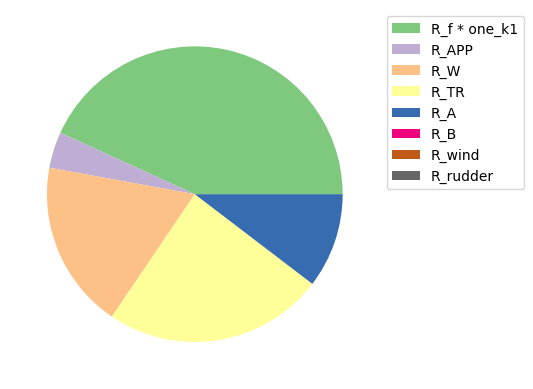

In [41]:
fractions_10 = np.abs(energycalculation_10.fractions());
import matplotlib.cm as cm


plt.figure()
# voor welke snelheid is dit dan? of het geheel.

labels = ["R_f * one_k1", "R_APP", "R_W", "R_TR", "R_A", "R_B", "R_wind", "R_rudder"]
colormap = 'Pastel1'

colors = cm.Accent(np.linspace(0, 1, len(fractions_10)))
plt.pie(fractions_10, colors=colors)
# plt.legend(labels=labels, loc='right')

plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1,1))